In [16]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, mean_squared_error, precision_recall_curve

In [17]:
# Load data
data = pd.read_csv(r'processed_data\preprocessed_training.csv')
X = data.drop(columns=["Churn"])
y = data["Churn"]

In [18]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
# Hyperparameter tuning for XGBoost
xgb_params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'scale_pos_weight': [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])]
}

xgb = XGBClassifier()
xgb_search = RandomizedSearchCV(xgb, xgb_params, cv=3, scoring='f1', n_iter=10, random_state=42)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

In [20]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [21]:
# Train Decision Tree
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [22]:
# Evaluate Models
models = {"XGBoost": best_xgb, "RandomForest": rf, "DecisionTree": dt}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]
    mse = mean_squared_error(y_test, y_probs)
    print(f"\n{name} Model:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(classification_report(y_test, y_pred))


XGBoost Model:
Mean Squared Error (MSE): 0.007565049454569817
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     38167
           1       1.00      0.98      0.99     50000

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167


RandomForest Model:
Mean Squared Error (MSE): 0.007678236982090805
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     38167
           1       1.00      0.99      0.99     50000

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167


DecisionTree Model:
Mean Squared Error (MSE): 0.041288847740170095
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     38167
           1       0.99      0.92     

In [23]:
# Feature Importance for XGBoost
feature_importance = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": best_xgb.feature_importances_}
)
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
selected_features = feature_importance[feature_importance["Importance"] > 0]["Feature"].tolist()

In [24]:
# Retrain with Selected Features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

best_xgb.fit(X_train_selected, y_train)
y_pred = best_xgb.predict(X_test_selected)
y_probs = best_xgb.predict_proba(X_test_selected)[:, 1]

In [25]:
# Calculate MSE again
mse_selected = mean_squared_error(y_test, y_probs)
print("\nXGBoost Model with Selected Features:")
print(f"Mean Squared Error (MSE): {mse_selected}")
print(classification_report(y_test, y_pred))


XGBoost Model with Selected Features:
Mean Squared Error (MSE): 0.007565049454569817
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     38167
           1       1.00      0.98      0.99     50000

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167



In [26]:
# Optimal Threshold using Precision-Recall Curve
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
optimal_threshold = thresholds[np.argmax(prec * rec)]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

y_pred_opt = (y_probs > optimal_threshold).astype("int32")
print("\nFinal Classification Report (XGBoost with Optimal Threshold):")
print(classification_report(y_test, y_pred_opt))

Optimal Threshold: 0.4291

Final Classification Report (XGBoost with Optimal Threshold):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     38167
           1       1.00      0.98      0.99     50000

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167



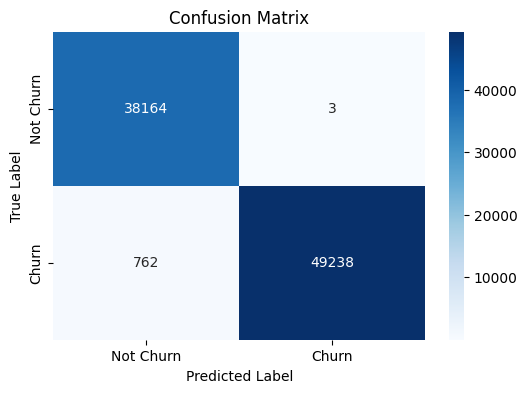

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
# Save best model
import joblib
joblib.dump(model, r"models/best_model.joblib")
print(f"Best model saved as best_model.joblib")

Best model saved as best_model.joblib
